In [33]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import networkx as nx

from qiskit import  QuantumCircuit, QuantumRegister, transpile,IBMQ
from qiskit.circuit import ParameterVector
from qiskit.opflow import X, Z, I,Y


from qiskit.algorithms import MinimumEigensolver, VQEResult
from qiskit.providers.aer import QasmSimulator, Aer
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator,
                                Sampler as RuntimeSampler,
                                Options)
from qiskit.primitives import Sampler,Estimator
from qiskit_aer.noise import NoiseModel


from lib import util1
import statistics

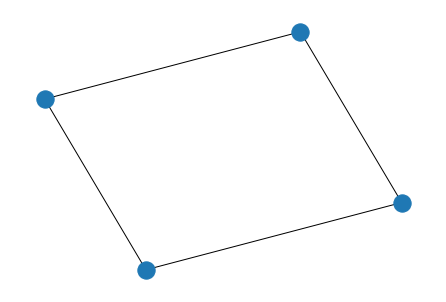

In [34]:
g = nx.Graph()
 
g.add_edge(0, 1)
g.add_edge(1, 2)
g.add_edge(2, 3)
g.add_edge(0, 3)

nx.draw(g)
plt.show()

In [35]:
from qiskit.opflow import X, Z, I,Y


def Ising_PBC_dual(g,h):
  E1 = Z^Z^I^I
  E2 = I^Z^Z^I
  E3 = I^I^Z^Z
  E4 = Z^I^I^Z
  B1 = X^I^I^I
  B2 = I^X^I^I
  B3 = I^I^X^I
  B4 = I^I^I^X


  H=(h*B1) + \
    (h*B2) + \
    (h*B3) + \
    (h*B4) + \
    (g*E1) + \
    (g*E2) + \
    (g*E3) + \
    (g*E4) 
  return H

In [36]:
g=1
h=1
edge_list=[[0,1],[2,3],[1,2],[0,3]]
initial_layout=[0,1,2,3]

In [37]:
def ansatz_ising(num_qubits,measure_list,depth):
  theta = ParameterVector("t",depth*(len(measure_list)+2*num_qubits))
  qr=QuantumRegister(num_qubits)
  circuit = QuantumCircuit(qr)
  index = 0

  circuit.x(qr[i] for i in range (0,num_qubits))
  circuit.h(qr[i] for i in range (0,num_qubits))
  for _ in range (0,depth): 
    for edge in measure_list:
      circuit.cx(qr[edge[1]],qr[edge[0]])
      circuit.rz(theta[index],qr[edge[0]])
      circuit.cx(qr[edge[1]],qr[edge[0]])
      index+=1
    circuit.barrier()
    for i in range (0,num_qubits):
      circuit.rx(theta[index], qr[i])
      index+=1
  #circuit=transpile(circuit,optimization_level=3,coupling_map=[[0,1],[1,2],[1,3]],basis_gates=['cx', 'id', 'rz', 'sx', 'x'])
  print(circuit.count_ops())
  return circuit

In [38]:
ansatz=ansatz_ising(4,edge_list,2)
ansatz.draw()

OrderedDict([('cx', 16), ('rz', 8), ('rx', 8), ('x', 4), ('h', 4), ('barrier', 2)])


┌───┐┌───┐┌───┐┌──────────┐┌───┐     ┌───┐┌──────────┐     ┌───┐ ░ »
q9037_0: ┤ X ├┤ H ├┤ X ├┤ Rz(t[0]) ├┤ X ├─────┤ X ├┤ Rz(t[3]) ├─────┤ X ├─░─»
         ├───┤├───┤└─┬─┘└──────────┘└─┬─┘┌───┐└─┬─┘├──────────┤┌───┐└─┬─┘ ░ »
q9037_1: ┤ X ├┤ H ├──■────────────────■──┤ X ├──┼──┤ Rz(t[2]) ├┤ X ├──┼───░─»
         ├───┤├───┤┌───┐┌──────────┐┌───┐└─┬─┘  │  └──────────┘└─┬─┘  │   ░ »
q9037_2: ┤ X ├┤ H ├┤ X ├┤ Rz(t[1]) ├┤ X ├──■────┼────────────────■────┼───░─»
         ├───┤├───┤└─┬─┘└──────────┘└─┬─┘       │                     │   ░ »
q9037_3: ┤ X ├┤ H ├──■────────────────■─────────■─────────────────────■───░─»
         └───┘└───┘                                                       ░ »
«         ┌──────────┐┌───┐┌──────────┐┌───┐     ┌───┐┌───────────┐     ┌───┐»
«q9037_0: ┤ Rx(t[4]) ├┤ X ├┤ Rz(t[8]) ├┤ X ├─────┤ X ├┤ Rz(t[11]) ├─────┤ X ├»
«         ├──────────┤└─┬─┘└──────────┘└─┬─┘┌───┐└─┬─┘├───────────┤┌───┐└─┬─┘»
«q9037_1: ┤ Rx(t[5]) ├──■────────────────■──┤ X ├──┼──┤ Rz(t[10]) ├┤ X ├──┼──»
«         ├──────────┤┌───┐┌──────────┐┌───┐└─┬─┘  │  └───────────┘└─┬─┘  │  »
«q9037_2: ┤ Rx(t[6]) ├┤ X ├┤ Rz(t[9]) ├┤ X ├──■────┼─────────────────■────┼──»
«         ├──────────┤└─┬─┘└──────────┘└─┬─┘       │                      │  »
«q9037_3: ┤ Rx(t[7]) ├──■────────────────■─────────■──────────────────────■──»
«         └──────────┘                                                       »
«          ░ ┌───────────┐
«q9037_0: ─░─┤ Rx(t[12]) ├
«          ░ ├───────────┤
«q9037_1: ─░─┤ Rx(t[13]) ├
«          ░ ├───────────┤
«q9037_2: ─░─┤ Rx(t[14]) ├
«          ░ ├───────────┤
«q9037_3: ─░─┤ Rx(t[15]) ├
«          ░ └───────────┘

In [39]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=20)
exact_result = exact_solver.compute_eigenvalues(Ising_PBC_dual(1,1))
print(exact_result.eigenvalues)


# Save ground state energy for later
gs_energy_ising= np.round(exact_result.eigenvalues[0], 4)

[-5.22625186e+00 -4.82842712e+00 -2.16478440e+00 -2.00000000e+00
 -2.00000000e+00 -8.28427125e-01 -3.80801243e-16 -1.39552899e-16
  1.09855663e-16  1.65949938e-15  8.28427125e-01  2.00000000e+00
  2.00000000e+00  2.16478440e+00  4.82842712e+00  5.22625186e+00]


In [40]:
from qiskit.algorithms.optimizers import SPSA,COBYLA,L_BFGS_B,SLSQP,NFT

spsa = SPSA(maxiter=5,blocking=False, allowed_increase=1, trust_region=False,
                 learning_rate=None, perturbation=None, last_avg=10, resamplings=0,
                 perturbation_dims=None, second_order=False, regularization=None, 
                 hessian_delay=0, lse_solver=None, initial_hessian=None, callback=None,
                 termination_checker=None)

cobyla=COBYLA(maxiter=50, disp=True, rhobeg=1.0, tol=1e-7, options=None)
slsqp=SLSQP(maxiter=100, disp=False, ftol=1e-06, tol=None, eps=1.4901161193847656e-08, options=None, max_evals_grouped=1)
nft=NFT(maxiter=50, maxfev=1024, disp=True, reset_interval=100, options=None)

In [41]:

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class Miti_CustomVQE(MinimumEigensolver):
    
    def __init__(self, sampler, circuit, optimizer,level_miti,callback=None):
        self._sampler = sampler
        self._circuit = circuit
        self._optimizer = optimizer
        self._level_miti=level_miti
        self._callback = callback
        
    def compute_minimum_eigenvalue(self,ham):
                
        # Define objective function to classically minimize over
        def objective(x):
            energy=0
            qc_cal_bound=transpile(self._circuit.assign_parameters(x),basis_gates=['cx', 'id', 'rz', 'sx', 'x'],optimization_level=0)
            energy_mean,energy_error=util1.miti_estimator(qc_cal_bound,ham,self._sampler,shots=10000,level_miti=self._level_miti)
            energy_mean=energy_mean.real
            energy_error=energy_error.real
            print('miti_sampler')
            print(energy_mean,energy_error)
            estimator_ideal = Estimator([self._circuit], [ham])
            job = estimator_ideal.run([self._circuit], [ham], [x])
            est_result = job.result()
            print('ideal_energy')
            print(est_result.values[0])

            if self._callback is not None:
                data=[energy_mean,energy_error,est_result.values[0],x]
                self._callback(data)  
            return energy_mean
            
        # Select an initial point for the ansatzs' parameters

       # Select an initial point for the ansatzs' parameters
        #x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        x0 = np.ones(self._circuit.num_parameters)*np.pi/4
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [42]:


# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            estimator_ideal = Estimator([self._circuit], [operators])
            job = estimator_ideal.run([self._circuit], [operators], [x])
            ideal_result = job.result().values[0]
            print('ideal_energy')
            print(ideal_result)

            # Save result information using callback function
            if self._callback is not None:

                self._callback([value,ideal_result,x])
                print('miti_energy')
                print(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        #x0 = np.ones(self._circuit.num_parameters)*np.pi/4
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

miti_sampler
-4.02088 0.07484868000144816
ideal_energy
-3.9999999999999956
miti_sampler
-2.66484 0.08291425617800006
ideal_energy
-2.6598691193323294
miti_sampler
-2.6227600000000004 0.08294414151852376
ideal_energy
-2.659869119332329
miti_sampler
-2.65388 0.07887657110566963
ideal_energy
-2.6598691193323294
miti_sampler
-2.6081199999999995 0.08113021028204084
ideal_energy
-2.6598691193323285
miti_sampler
-4.37624 0.07661521136331152
ideal_energy
-4.381773290676032
miti_sampler
-4.227040000000001 0.07104785395084366
ideal_energy
-4.252536447886155
miti_sampler
-4.471520000000001 0.06992280291397744
ideal_energy
-4.515170857210355
miti_sampler
-3.91448 0.07561233027619187
ideal_energy
-3.874923880954569
miti_sampler
-3.9396000000000004 0.07459513580465071
ideal_energy
-3.9249273357131926
miti_sampler
-3.9158 0.07218288564190153
ideal_energy
-3.9249273357131926
miti_sampler
-3.93372 0.0744418030465163
ideal_energy
-3.924927335713191
miti_sampler
-3.98104 0.06707415329928752
ideal_energy


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


miti_sampler
-5.0571600000000005 0.06512018402420974
ideal_energy
-5.066691973767668
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 50,
    'eigenstate': None,
    'eigenvalue': -5.11864,
    'optimal_circuit': None,
    'optimal_parameters': array([0.44374117, 0.30731834, 0.32935392, 0.37099379, 1.85510704,
       0.69185925, 1.81361858, 0.64401123, 0.65826659, 0.65041789,
       0.65139047, 0.66747385, 0.59193316, 0.69365209, 0.58276206,
       0.76446346]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 23.29


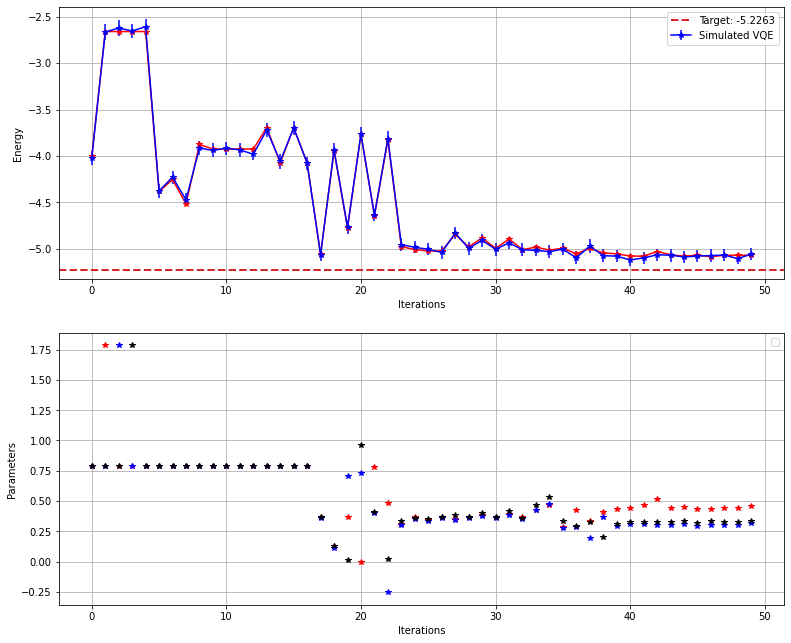

In [43]:
# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)
# Define instance of qiskit-terra's Estimator primitive
estimator = Sampler()


# Setup VQE algorithm
custom_vqe = Miti_CustomVQE(estimator,ansatz,cobyla,level_miti=0,callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [44]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-5.074084999999999
0.014932326390371137


In [45]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token="c0df7c866f628346a4ad9eb0955b0b9e8ffedc7dc25fa33a87a59e50864c059fa00f211c7f611efee085a4b810646179209cc819b26a4903c733466bb8b96f51",overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = 'ibmq_belem'

options = Options()
options.resilience_level = 0
options.optimization_level = 3
options.initial_layout=initial_layout

options.shots=10000

In [46]:
# Define a simple callback function
intermediate_info_real_backend_0= []
def callback(value):
        intermediate_info_real_backend_0.append(value)



# Define a simple callback function

start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=0,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')



miti_sampler
-1.90272 0.08875084132972877
ideal_energy
-3.9999999999999956
miti_sampler
-1.0812 0.08740106009724624
ideal_energy
-2.6598691193323294
miti_sampler
-0.86204 0.08730962029420565
ideal_energy
-2.659869119332329
miti_sampler
-0.84104 0.08726651647659132
ideal_energy
-2.6598691193323294
miti_sampler
-0.91844 0.09113193844136991
ideal_energy
-2.6598691193323285
miti_sampler
-2.0898000000000003 0.08343906978955924
ideal_energy
-4.381773290676032
miti_sampler
-1.9487199999999998 0.08024059738927519
ideal_energy
-4.252536447886155
miti_sampler
-2.0414400000000006 0.07985544082009333
ideal_energy
-4.515170857210355
miti_sampler
-2.0204400000000002 0.08358645530350046
ideal_energy
-4.252536447886155
miti_sampler
-1.4512800000000001 0.08816428079536102
ideal_energy
-3.8892900342858994
miti_sampler
-1.291 0.07879988604570648
ideal_energy
-3.374627751709857
miti_sampler
-1.393 0.08252869878078159
ideal_energy
-3.374627751709858
miti_sampler
-1.5608800000000003 0.0857336739976939
ideal

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


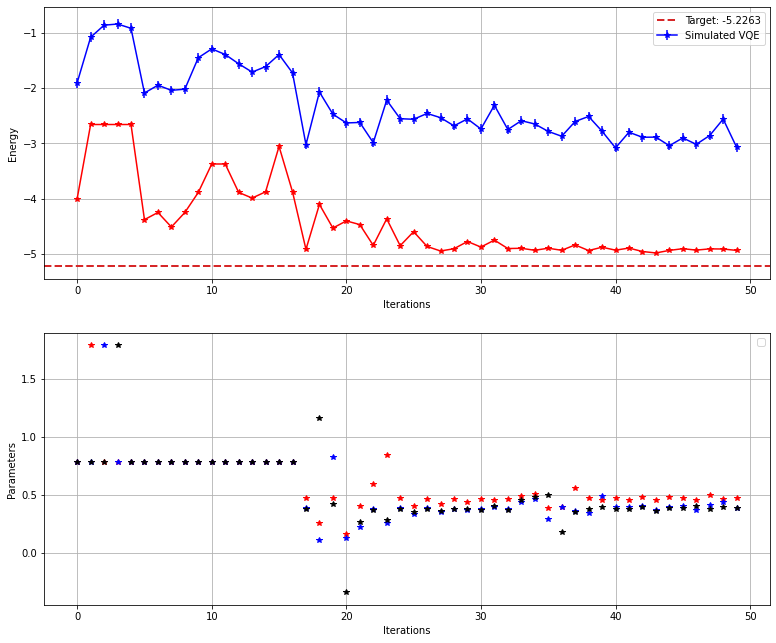

In [47]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_0:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [48]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-2.90468
0.16057569002987784


In [49]:
# Define a simple callback function
intermediate_info_real_backend_1= []
def callback(value):
        intermediate_info_real_backend_1.append(value)



# Define a simple callback function

start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=1,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


NameError: name 'simulator' is not defined

In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_1:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_2= []
def callback(value):
        intermediate_info_real_backend_2.append(value)

start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=2,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_2:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_3= []
def callback(value):
        intermediate_info_real_backend_3.append(value)

start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=3,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_3:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_4= []
def callback(value):
        intermediate_info_real_backend_4.append(value)

start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=4,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_4:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_raw= []
def callback(value):
        intermediate_info_real_backend_raw.append(value)



options = Options()
options.resilience_level = 0
options.optimization_level = 3
options.initial_layout=initial_layout
options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameters=[]
ideal_energy=[]
for data in intermediate_info_real_backend_raw:
  energies_miti.append(data[0])
  ideal_energy.append(data[1])
  parameters.append(list(data[2]))

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_meas= []
def callback(value):
        intermediate_info_real_backend_meas.append(value)



options = Options()
options.resilience_level = 1
options.optimization_level = 3
options.initial_layout=initial_layout

options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameters=[]
ideal_energy=[]
for data in intermediate_info_real_backend_meas:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_zne= []
def callback(value):
        intermediate_info_real_backend_zne.append(value)


options = Options()
options.resilience_level = 2
options.optimization_level = 3
options.initial_layout=initial_layout
options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameters=[]
ideal_energy=[]
for data in intermediate_info_real_backend_zne:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_PEC= []
def callback(value):
        intermediate_info_real_backend_PEC.append(value)



# Define a simple callback function
simulator = service.get_backend('ibmq_qasm_simulator')
options = Options()
options.resilience_level = 3
options.optimization_level = 3
options.initial_layout=[1,2]
options.simulator = {
    "noise_model": backend_noise_model
}
options.shots=10000
start = time()
with Session(service=service, backend=simulator) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameteres=[]
ideal_energy=[]
for data in intermediate_info_real_backend_zne:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)